In [61]:
import numpy as np
import numpy.random as rnd
import matplotlib.pyplot as plt
import itertools
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve


def plot(image):
    plt.figure()
    plt.imshow(image.reshape((32, 32))
               if image.shape[0] != 32 else image, cmap="gray")
    plt.show()


def plot_confusion_matrix(
    cm, classes, normalize=False, title="Confusion matrix", cmap=plt.cm.Blues
):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print("Confusion matrix, without normalization")

    fig = plt.figure(figsize=(6.5, 6.5))
    plt.imshow(cm, interpolation="none", cmap=cmap)
    plt.title(title)
    plt.colorbar(fraction=0.046, pad=0.04)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, ha="right")
    plt.yticks(tick_marks, classes)

    fmt = ".2f" if normalize else "d"
    thresh = cm.max() / 2.0
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(
            j,
            i,
            format(cm[i, j], fmt),
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black",
        )

    plt.tight_layout()
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    # return fig


# Get data

In [62]:
import keras.datasets.cifar10 as cifar10

(Xtrain, ytrain), (Xtest, ytest) = cifar10.load_data()

ytrain = ytrain.squeeze()
ytest = ytest.squeeze()

print(Xtrain.shape, ytrain.shape)
print(Xtest.shape, ytest.shape)


(50000, 32, 32, 3) (50000,)
(10000, 32, 32, 3) (10000,)


# Randomize train data and sort test data

In [63]:
idx = rnd.permutation(Xtrain.shape[0])
Xtrain = Xtrain[idx]
ytrain = ytrain[idx]

idx = np.argsort(ytest)
Xtest = Xtest[idx]
ytest = ytest[idx]


# Convert images to grayscale

In [64]:
from skimage import color

XtrainG = np.zeros((Xtrain.shape[0], 32, 32))
for i in range(Xtrain.shape[0]):
    XtrainG[i] = color.rgb2gray(Xtrain[i])

XtestG = np.zeros((Xtest.shape[0], 32, 32))
for i in range(Xtest.shape[0]):
    XtestG[i] = color.rgb2gray(Xtest[i])


# Convert images to vectors

In [65]:
XtrainG = XtrainG.reshape((XtrainG.shape[0], XtrainG.shape[1] ** 2)) * 1.0
XtestG = XtestG.reshape((XtestG.shape[0], XtestG.shape[1] ** 2)) * 1.0

print(XtrainG.shape, ytrain.shape)
print(XtestG.shape, ytest.shape)


(50000, 1024) (50000,)
(10000, 1024) (10000,)


# Normalization

In [66]:
from sklearn.preprocessing import StandardScaler

ss = StandardScaler().fit(XtrainG)
XtrainGS = ss.transform(XtrainG)
XtestGS = ss.transform(XtestG)


# Binarize for ship (index 8)

In [67]:
ytrainB = (ytrain == 8) * 1
ytestB = (ytest == 8) * 1


#### Change names

In [68]:
X1 = XtrainG
X1s = XtrainGS
y1 = ytrain
y1b = ytrainB
X2 = XtestG
X2s = XtestGS
y2 = ytest
y2b = ytestB

#! Takes a lot of time to train specially on model fine tuning. Needs to be optimized somehow


# Binary classification

## SGDClassifier

In [69]:
from sklearn.linear_model import SGDClassifier


### Not normalized data

Score: 0.8993
Number of errors: 1007
              precision    recall  f1-score   support

           0       0.90      1.00      0.95      9000
           1       0.35      0.01      0.02      1000

    accuracy                           0.90     10000
   macro avg       0.62      0.50      0.48     10000
weighted avg       0.85      0.90      0.85     10000



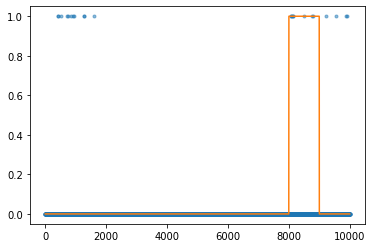

Prediction
[[8985   15]
 [ 992    8]]


In [70]:
sgdb = SGDClassifier().fit(X1, y1b)

y2e = sgdb.predict(X2)
print('Score:', sgdb.score(X2, y2b))
print("Number of errors:", np.sum(y2b != y2e))
print(classification_report(y2b, y2e))

plt.figure()
plt.plot(y2e, ".", alpha=0.5)
plt.plot(y2b)
plt.show()

print('Prediction')
cm = confusion_matrix(y2b, y2e)
print(cm)


#### Decision function

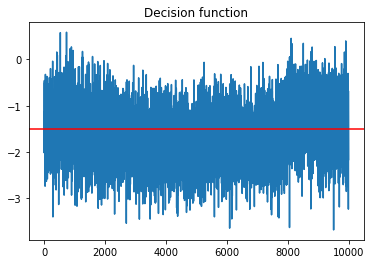

Decision function with threshold = -1.5
[[5530 3470]
 [ 238  762]]


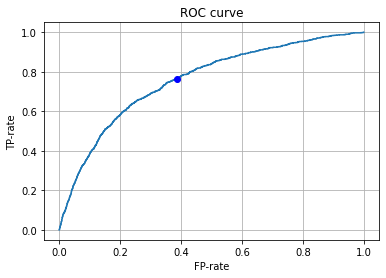

In [87]:
th = -1.5

y2d = sgdb.decision_function(X2)
plt.figure()
plt.plot(y2d)
plt.axhline(th, color='r')
plt.title("Decision function")
plt.show()

print(f'Decision function with threshold = {th}')
cm = confusion_matrix(y2b, (y2d >= th)*1)
print(cm)

fp, tp, t = roc_curve(y2b, y2d)
plt.figure()
plt.plot(fp, tp)
plt.plot(cm[0][1] / (cm[0][0] + cm[0][1]),
         cm[1][1] / (cm[1][0] + cm[1][1]), 'ob')
plt.title('ROC curve')
plt.xlabel("FP-rate")
plt.ylabel("TP-rate")
plt.grid(True)
plt.show()


### Normalized data

Score: 0.8847
Number of errors: 1153
              precision    recall  f1-score   support

           0       0.90      0.97      0.94      9000
           1       0.25      0.08      0.12      1000

    accuracy                           0.88     10000
   macro avg       0.58      0.53      0.53     10000
weighted avg       0.84      0.88      0.86     10000



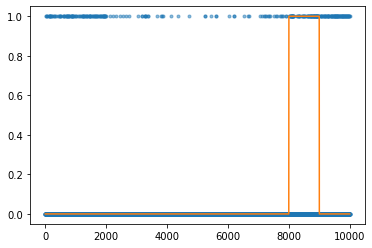

Prediction
[[8770  230]
 [ 923   77]]


In [72]:
sgdbn = SGDClassifier().fit(X1s, y1b)

y2e = sgdbn.predict(X2s)
print('Score:', sgdbn.score(X2s, y2b))
print("Number of errors:", np.sum(y2b != y2e))
print(classification_report(y2b, y2e))

plt.figure()
plt.plot(y2e, ".", alpha=0.5)
plt.plot(y2b)
plt.show()

print('Prediction')
cm = confusion_matrix(y2b, y2e)
print(cm)


#### Decision function

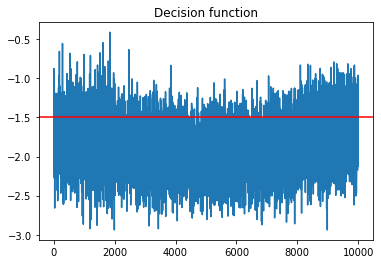

Decision function with threshold = -1.5
[[7786 1214]
 [ 715  285]]


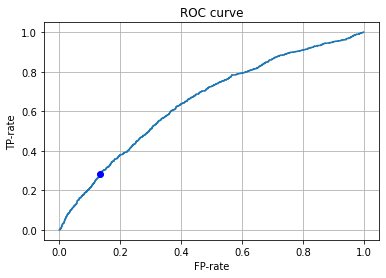

In [86]:
th = -1.5

y2d = sgdbn.decision_function(X2)
plt.figure()
plt.plot(y2d)
plt.axhline(th, color='r')
plt.title("Decision function")
plt.show()

print(f'Decision function with threshold = {th}')
cm = confusion_matrix(y2b, (y2d >= th)*1)
print(cm)

fp, tp, t = roc_curve(y2b, y2d)
plt.figure()
plt.plot(fp, tp)
plt.plot(cm[0][1] / (cm[0][0] + cm[0][1]),
         cm[1][1] / (cm[1][0] + cm[1][1]), 'ob')
plt.title('ROC curve')
plt.xlabel("FP-rate")
plt.ylabel("TP-rate")
plt.grid(True)
plt.show()


We can see that without any normalization, the classifier doesn't guess any image as ship, resulting in a score of 0.9 because every other class isn't a ship.
With normalization, the classifier was able to guess some of the images as ship, despite getting a bit more errors.

## RandomForestClassifier
why

In [74]:
from sklearn.ensemble import RandomForestClassifier


### Not normalized data

Score: 0.9144
Number of errors: 856
              precision    recall  f1-score   support

           0       0.92      1.00      0.95      9000
           1       0.82      0.19      0.30      1000

    accuracy                           0.91     10000
   macro avg       0.87      0.59      0.63     10000
weighted avg       0.91      0.91      0.89     10000



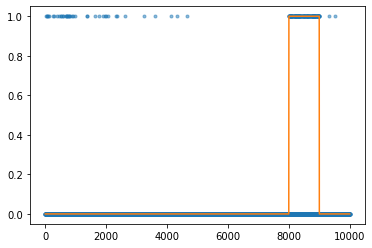

Prediction
[[8958   42]
 [ 814  186]]


In [75]:
rfcb = RandomForestClassifier().fit(X1, y1b)

y2e = rfcb.predict(X2)
print('Score:', rfcb.score(X2, y2b))
print("Number of errors:", np.sum(y2b != y2e))
print(classification_report(y2b, y2e))

plt.figure()
plt.plot(y2e, ".", alpha=0.5)
plt.plot(y2b)
plt.show()

print('Prediction')
cm = confusion_matrix(y2b, y2e)
print(cm)


#### Decision function

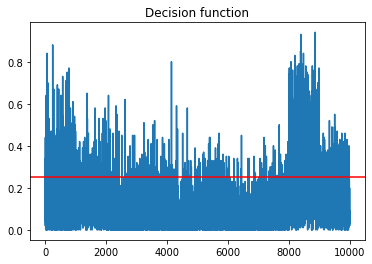

Decision function with threshold = 0.25
[[8215  785]
 [ 420  580]]


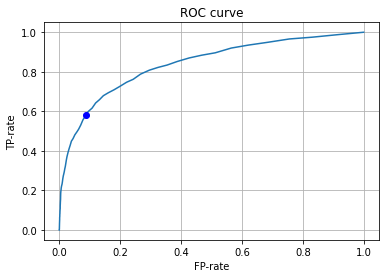

In [76]:
th = 0.25

y2d = rfcb.predict_proba(X2)[:, 1]
plt.figure()
plt.plot(y2d)
plt.axhline(th, color='r')
plt.title("Decision function")
plt.show()

print(f'Decision function with threshold = {th}')
cm = confusion_matrix(y2b, (y2d >= th)*1)
print(cm)

fp, tp, t = roc_curve(y2b, y2d)
plt.figure()
plt.plot(fp, tp)
plt.plot(cm[0][1] / (cm[0][0] + cm[0][1]),
         cm[1][1] / (cm[1][0] + cm[1][1]), 'ob')
plt.title('ROC curve')
plt.xlabel("FP-rate")
plt.ylabel("TP-rate")
plt.grid(True)
plt.show()


### Normalized data

Score: 0.9123
Number of errors: 877
              precision    recall  f1-score   support

           0       0.92      0.99      0.95      9000
           1       0.77      0.17      0.29      1000

    accuracy                           0.91     10000
   macro avg       0.84      0.58      0.62     10000
weighted avg       0.90      0.91      0.89     10000



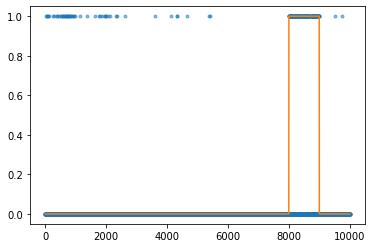

Prediction
[[8948   52]
 [ 825  175]]


In [77]:
rfcbn = RandomForestClassifier().fit(X1s, y1b)

y2e = rfcbn.predict(X2s)
print('Score:', rfcbn.score(X2s, y2b))
print("Number of errors:", np.sum(y2b != y2e))
print(classification_report(y2b, y2e))

plt.figure()
plt.plot(y2e, ".", alpha=0.5)
plt.plot(y2b)
plt.show()

print('Prediction')
cm = confusion_matrix(y2b, y2e)
print(cm)


#### Decision function

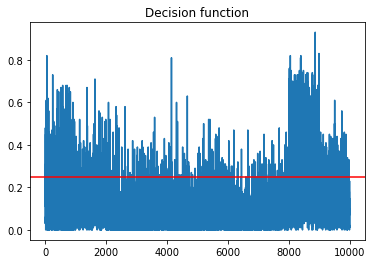

Decision function with threshold = 0.25
[[8226  774]
 [ 434  566]]


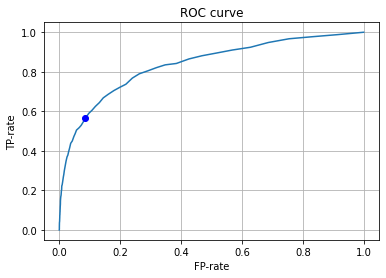

In [78]:
th = 0.25

y2d = rfcbn.predict_proba(X2s)[:, 1]
plt.figure()
plt.plot(y2d)
plt.axhline(th, color='r')
plt.title("Decision function")
plt.show()

print(f'Decision function with threshold = {th}')
cm = confusion_matrix(y2b, (y2d >= th)*1)
print(cm)

fp, tp, t = roc_curve(y2b, y2d)
plt.figure()
plt.plot(fp, tp)
plt.plot(cm[0][1] / (cm[0][0] + cm[0][1]),
         cm[1][1] / (cm[1][0] + cm[1][1]), 'ob')
plt.title('ROC curve')
plt.xlabel("FP-rate")
plt.ylabel("TP-rate")
plt.grid(True)
plt.show()


#### Compare normalization!

#### Compare classifiers!

# Multi-class classification

We used the SGDClassifier because it takes a significant less amount of time to train comparing to the RandomForestClassifier.

### Not normalized data

Score: 0.2218
Number of errors: 7782
              precision    recall  f1-score   support

           0       0.35      0.13      0.19      1000
           1       0.64      0.08      0.14      1000
           2       0.18      0.05      0.08      1000
           3       0.17      0.20      0.18      1000
           4       0.15      0.58      0.24      1000
           5       0.41      0.13      0.20      1000
           6       0.22      0.13      0.16      1000
           7       0.39      0.11      0.17      1000
           8       0.35      0.13      0.19      1000
           9       0.25      0.68      0.37      1000

    accuracy                           0.22     10000
   macro avg       0.31      0.22      0.19     10000
weighted avg       0.31      0.22      0.19     10000



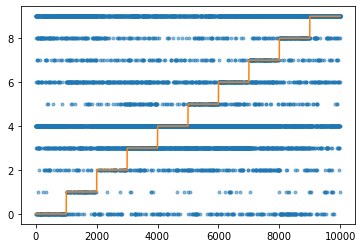

Prediction
Confusion matrix, without normalization


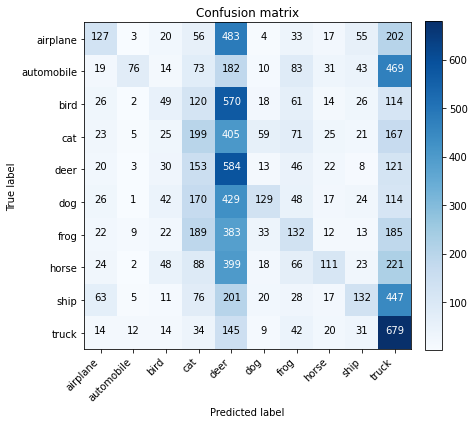

In [79]:
sgd = SGDClassifier().fit(X1, y1)

y2e = sgd.predict(X2)
print('Score:', sgd.score(X2, y2))
print("Number of errors:", np.sum(y2 != y2e))
print(classification_report(y2, y2e))

plt.figure()
plt.plot(y2e, ".", alpha=0.5)
plt.plot(y2)
plt.show()

print('Prediction')
cm = confusion_matrix(y2, y2e)
# print(cm)

plot_confusion_matrix(
    cm,
    classes=[
        "airplane",
        "automobile",
        "bird",
        "cat",
        "deer",
        "dog",
        "frog",
        "horse",
        "ship",
        "truck",
    ],
)


### Normalized data

Score: 0.2272
Number of errors: 7728
              precision    recall  f1-score   support

           0       0.25      0.44      0.32      1000
           1       0.31      0.18      0.23      1000
           2       0.11      0.09      0.10      1000
           3       0.14      0.19      0.16      1000
           4       0.19      0.15      0.17      1000
           5       0.21      0.23      0.22      1000
           6       0.20      0.08      0.11      1000
           7       0.22      0.19      0.21      1000
           8       0.27      0.30      0.29      1000
           9       0.33      0.42      0.37      1000

    accuracy                           0.23     10000
   macro avg       0.22      0.23      0.22     10000
weighted avg       0.22      0.23      0.22     10000



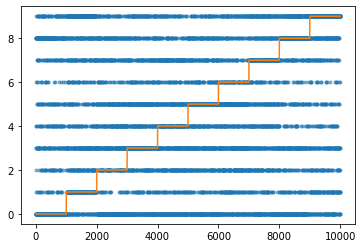

Prediction
Confusion matrix, without normalization


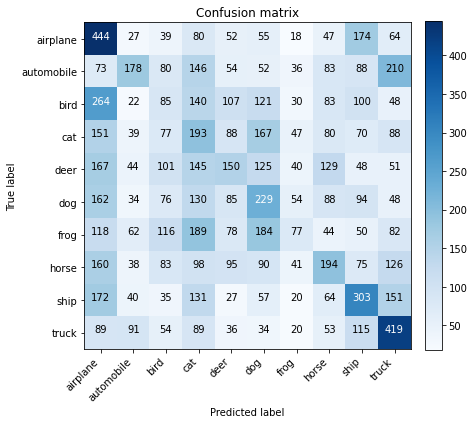

In [80]:
sgdn = SGDClassifier().fit(X1s, y1)

y2e = sgdn.predict(X2s)
print('Score:', sgdn.score(X2s, y2))
print("Number of errors:", np.sum(y2 != y2e))
print(classification_report(y2, y2e))

plt.figure()
plt.plot(y2e, ".", alpha=0.5)
plt.plot(y2)
plt.show()

print('Prediction')
cm = confusion_matrix(y2, y2e)
# print(cm)

plot_confusion_matrix(
    cm,
    classes=[
        "airplane",
        "automobile",
        "bird",
        "cat",
        "deer",
        "dog",
        "frog",
        "horse",
        "ship",
        "truck",
    ],
)


## PCA
The images are in grayscale and are already with a low resolution. We're expecting that the PCA will reduce the perfomance of the classifier.

In [81]:
from sklearn.decomposition import PCA


### Not normalized data

Score: 0.2305
Number of errors: 7695
              precision    recall  f1-score   support

           0       0.19      0.20      0.20      1000
           1       0.32      0.27      0.30      1000
           2       0.19      0.12      0.15      1000
           3       0.16      0.07      0.10      1000
           4       0.13      0.09      0.10      1000
           5       0.21      0.28      0.24      1000
           6       0.16      0.23      0.19      1000
           7       0.24      0.26      0.25      1000
           8       0.30      0.39      0.34      1000
           9       0.33      0.39      0.36      1000

    accuracy                           0.23     10000
   macro avg       0.22      0.23      0.22     10000
weighted avg       0.22      0.23      0.22     10000



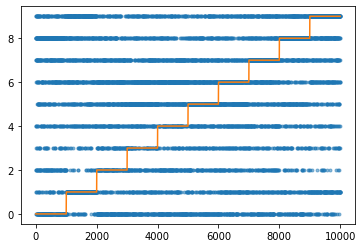

Prediction
Confusion matrix, without normalization


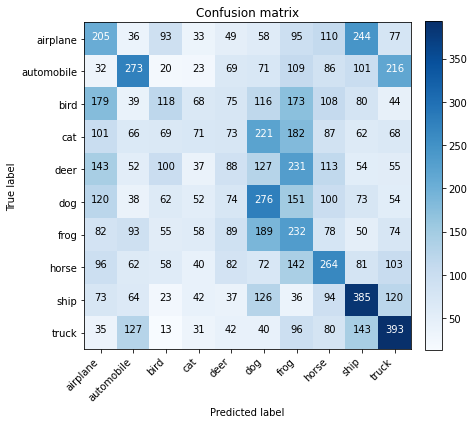

In [82]:
# Try different number of components
pca = PCA(n_components=None).fit(X1)
X1p = pca.transform(X1)
X2p = pca.transform(X2)

sgd = SGDClassifier().fit(X1p, y1)

y2e = sgd.predict(X2p)
print('Score:', sgd.score(X2p, y2))
print("Number of errors:", np.sum(y2 != y2e))
print(classification_report(y2, y2e))

plt.figure()
plt.plot(y2e, ".", alpha=0.5)
plt.plot(y2)
plt.show()

print('Prediction')
cm = confusion_matrix(y2, y2e)
# print(cm)

plot_confusion_matrix(
    cm,
    classes=[
        "airplane",
        "automobile",
        "bird",
        "cat",
        "deer",
        "dog",
        "frog",
        "horse",
        "ship",
        "truck",
    ],
)


### Normalized data

Score: 0.2085
Number of errors: 7915
              precision    recall  f1-score   support

           0       0.16      0.09      0.12      1000
           1       0.25      0.31      0.28      1000
           2       0.15      0.22      0.18      1000
           3       0.11      0.13      0.12      1000
           4       0.22      0.18      0.20      1000
           5       0.26      0.31      0.28      1000
           6       0.14      0.11      0.12      1000
           7       0.23      0.20      0.21      1000
           8       0.27      0.19      0.22      1000
           9       0.32      0.34      0.33      1000

    accuracy                           0.21     10000
   macro avg       0.21      0.21      0.21     10000
weighted avg       0.21      0.21      0.21     10000



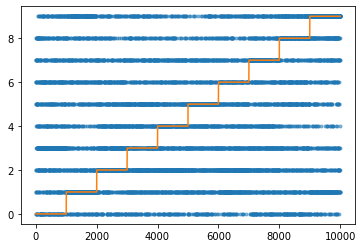

Prediction
Confusion matrix, without normalization


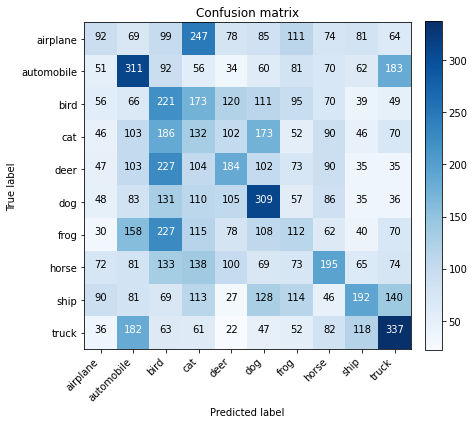

In [83]:
# Try different number of components
pca = PCA(n_components=None).fit(X1s)
X1sp = pca.transform(X1s)
X2sp = pca.transform(X2s)

sgdn = SGDClassifier().fit(X1sp, y1)

y2e = sgdn.predict(X2sp)
print('Score:', sgdn.score(X2sp, y2))
print("Number of errors:", np.sum(y2 != y2e))
print(classification_report(y2, y2e))

plt.figure()
plt.plot(y2e, ".", alpha=0.5)
plt.plot(y2)
plt.show()

print('Prediction')
cm = confusion_matrix(y2, y2e)
# print(cm)

plot_confusion_matrix(
    cm,
    classes=[
        "airplane",
        "automobile",
        "bird",
        "cat",
        "deer",
        "dog",
        "frog",
        "horse",
        "ship",
        "truck",
    ],
)


Confusion matrix, without normalization


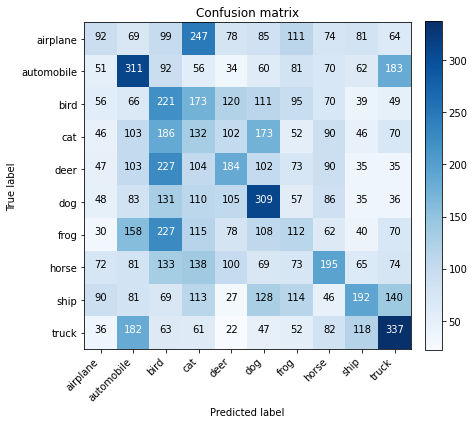

In [84]:
cm = confusion_matrix(y2, y2e)
plot_confusion_matrix(
    cm,
    classes=[
        "airplane",
        "automobile",
        "bird",
        "cat",
        "deer",
        "dog",
        "frog",
        "horse",
        "ship",
        "truck",
    ],
)


# Example preview

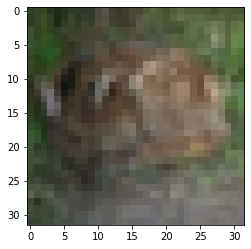

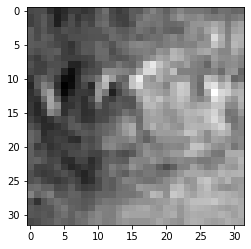

4


In [85]:
plot(Xtrain[0])
plot(XtrainG[0])
print(ytrain[0])
